## 1. Introduzione al Model Context Protocol (MCP)

https://modelcontextprotocol.io/docs/getting-started/intro

Il Model Context Protocol (MCP) è un protocollo open-source sviluppato da Anthropic per standardizzare il modo in cui le applicazioni AI si connettono a fonti di dati e strumenti esterni.

### Cos'è MCP?

MCP risolve un problema fondamentale nell'ecosistema dell'intelligenza artificiale: la frammentazione delle integrazioni. 

Invece di dover costruire integrazioni personalizzate per ogni combinazione di applicazione AI e fonte di dati, MCP fornisce un protocollo universale che permette ai modelli linguistici di interagire con qualsiasi sistema compatibile.

### Come funziona?
MCP segue un'architettura client-server:

- I server MCP espongono risorse (dati), strumenti (azioni) e prompt
- I client MCP (come Claude Desktop o altre applicazioni AI) si connettono a questi server
- Gli host mantengono connessioni persistenti tra client e server

### Vantaggi principali

- Universalità: un'unica integrazione funziona con tutti i client compatibili
- Sicurezza: controllo granulare degli accessi e delle autorizzazioni
- Semplicità: riduce drasticamente la complessità dello sviluppo
- Flessibilità: supporta database, API, file system e molto altro

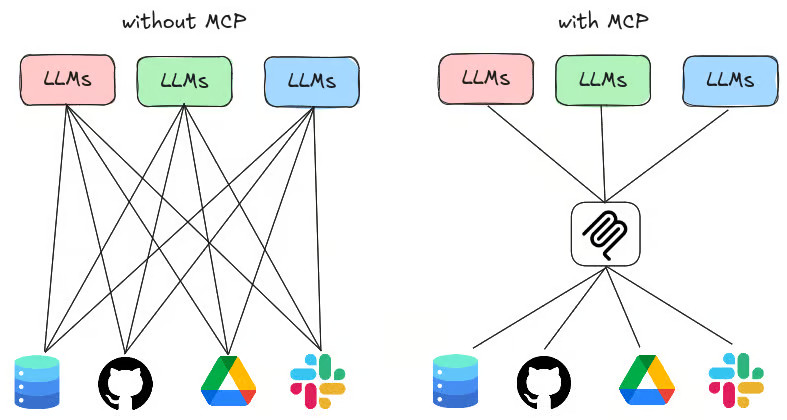

### Architettura di un architettura MCP

I tre punti fondamentali su cui l'architettura MCP punta:

1. **Tools**

sistema di function calling visto nella lezione precedente

2. **Resources**

novità di MCP,  non solo permette di  chiamare funzioni, ma anche esporre dati che l'LLM può leggere:
```python
# Esponi un file come risorsa
resources = [
    {
        "uri": "file:///docs/manual.pdf",
        "name": "Manuale Utente",
        "description": "Documentazione completa del prodotto",
        "mimeType": "application/pdf"
    }
]
```

3. **Prompts (Template Preconfigurati)**

permettte di costruire prompt template pronti all'uso

```python
prompts = [
    {
        "name": "analyze_bug",
        "description": "Analizza un bug report",
        "arguments": ["bug_id"]
    }
]
```


**Componenti:**

- **MCP Client**: L'applicazione che usa l'LLM 
- **MCP Server**: Il codice Python che espone tools/resources/prompts
- **JSON-RPC**: Protocollo di comunicazione standard (come REST ma per chiamate locali)
- **stdio**: I server comunicano via standard input/output (semplice!)

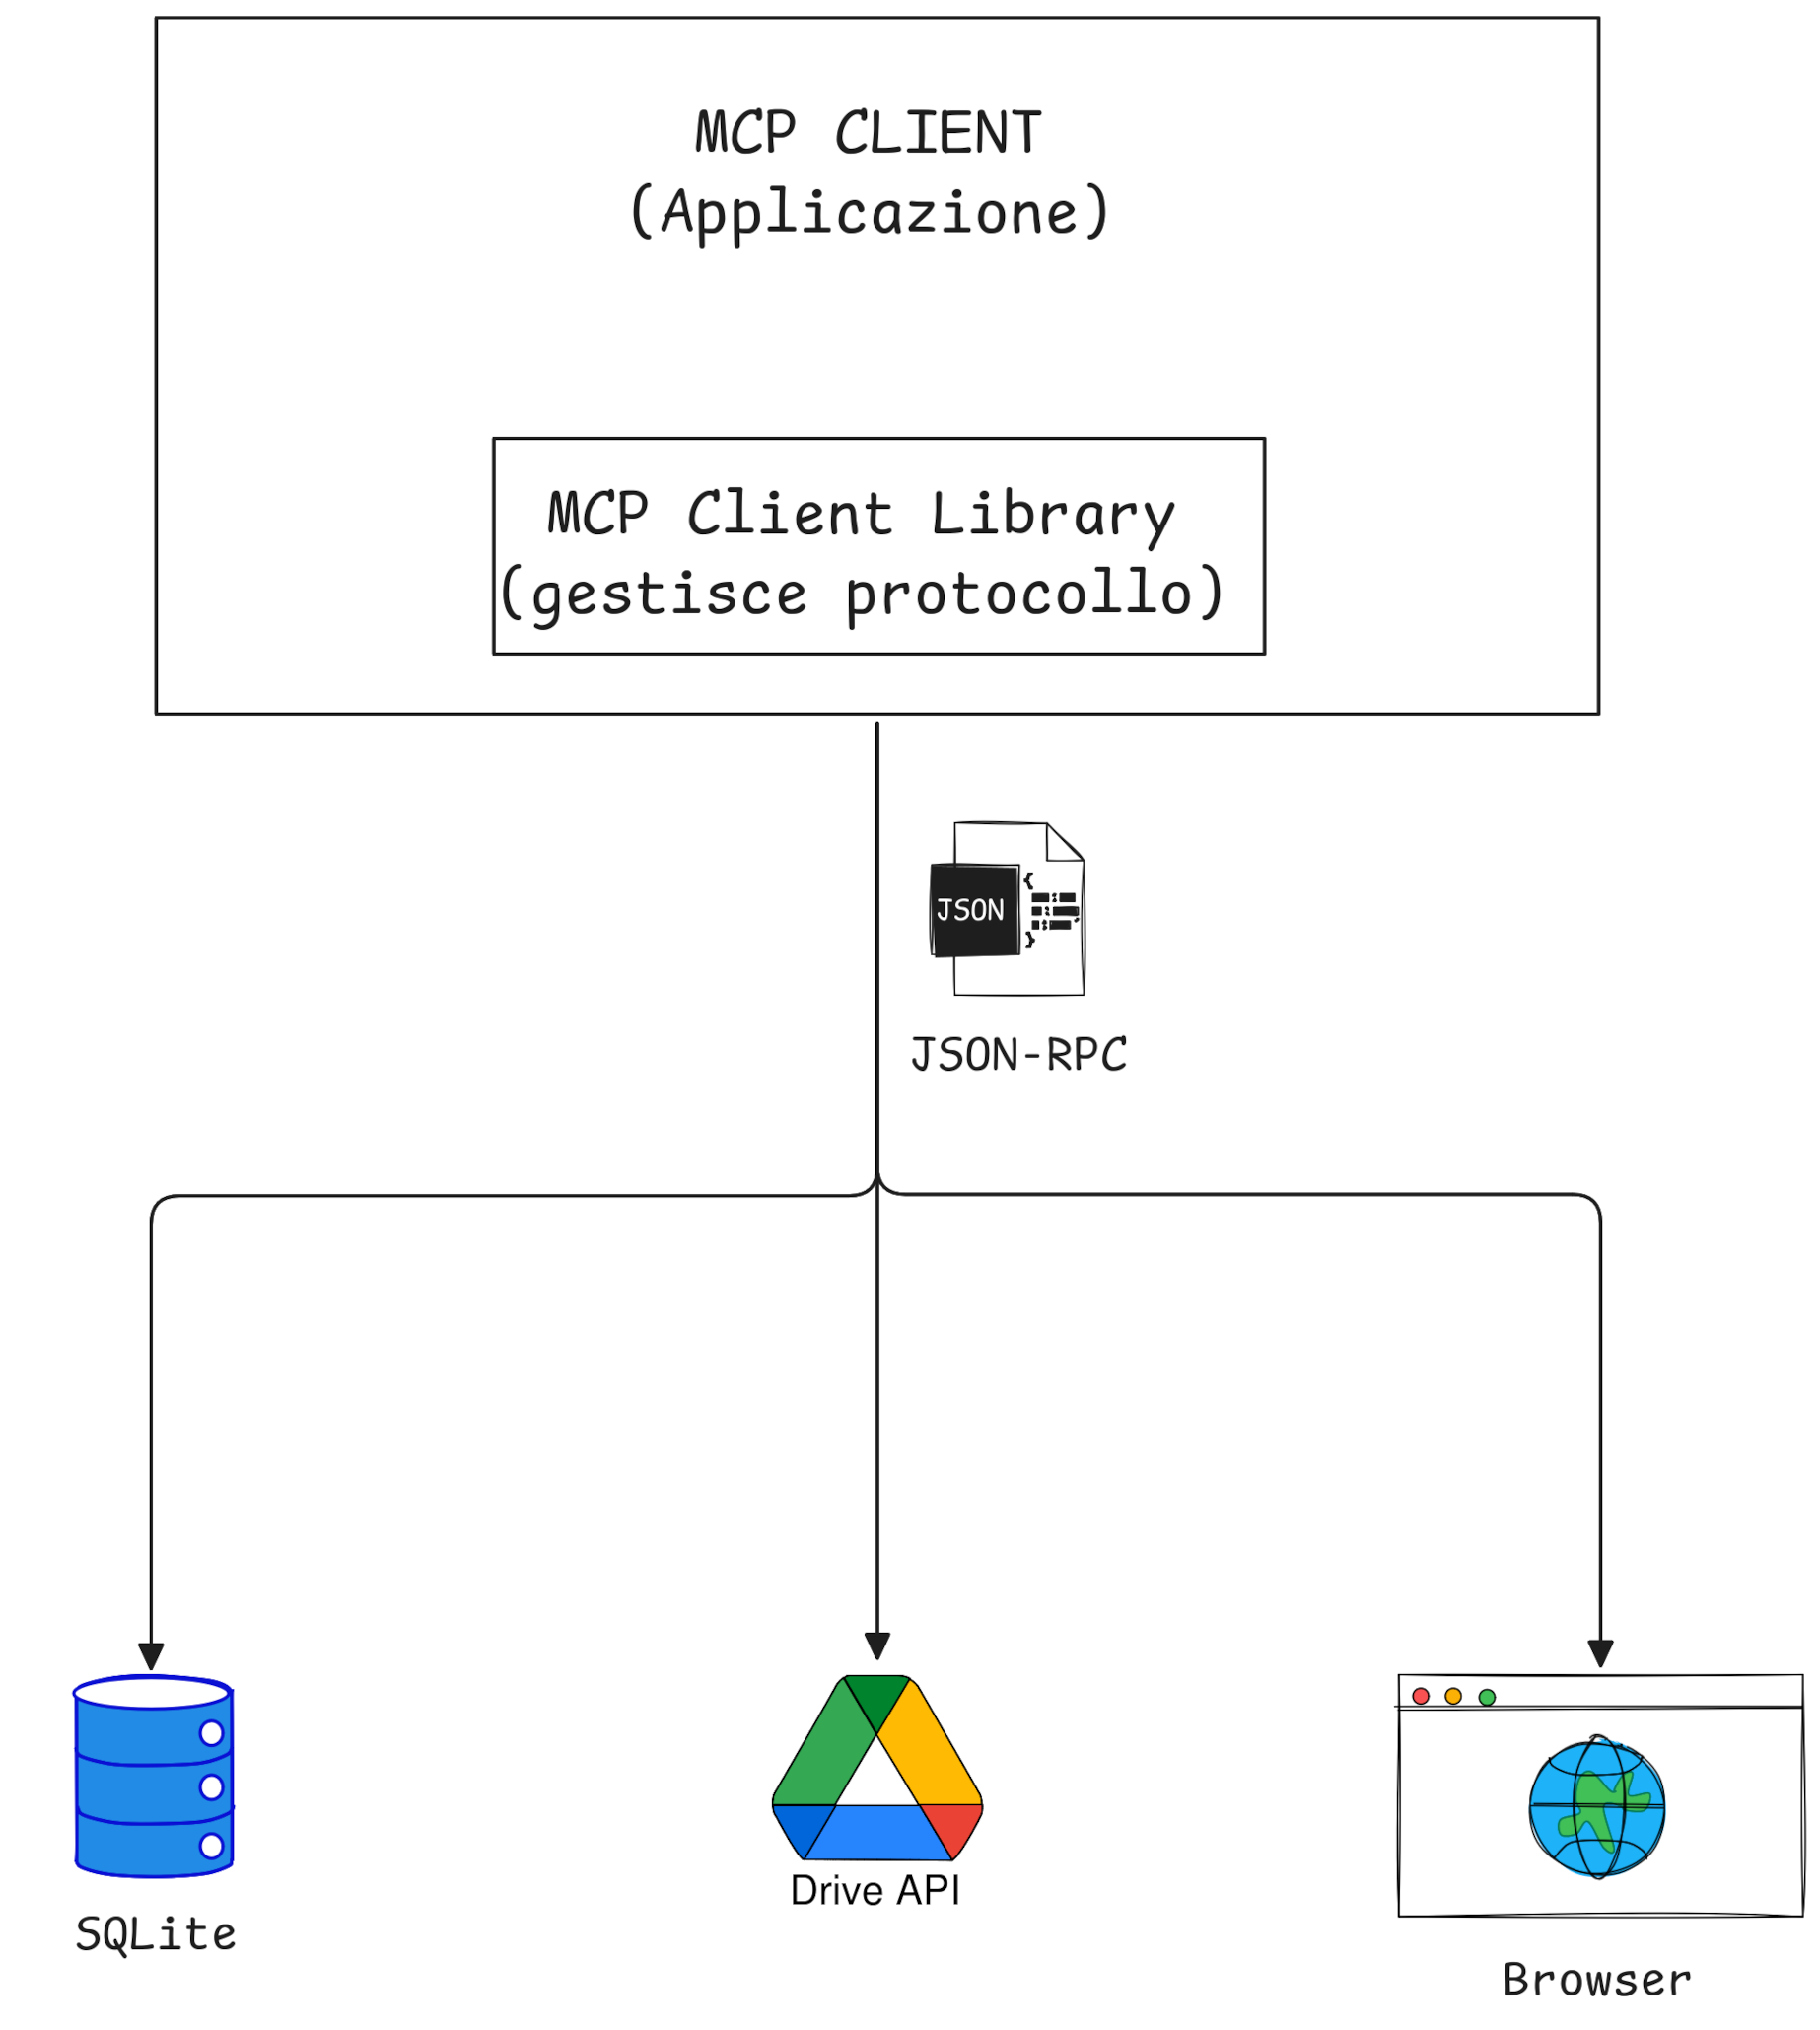

### MCP vs Function Calling Tradizionale

| Aspetto | Function Calling Tradizionale | MCP |
|---------|-------------------------------|-----|
| **Standard** | Ogni piattaforma diversa | Protocollo unico |
| **Portabilità** | Codice specifico per piattaforma | Scrivi una volta, usa ovunque |
| **Risorse** | No supporto nativo | Sì, integrate |
| **Prompts** | No supporto | Sì, template pronti |
| **Discovery** | Manuale | Automatica |
| **Comunicazione** | Varia | JSON-RPC standard |

# 2. MCP con SQLite e Ollama

```bash
pip install mcp
```

## 2.1 Creazione del Database

In [ ]:
import sqlite3
import json
from datetime import datetime
from pathlib import Path

DB_PATH =  Path("__ file__").parent.resolve() / "db" / "libreria.db"


def init_db():
    # Creazione del database
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Tabella Autori
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS autori (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        nome TEXT NOT NULL,
        cognome TEXT NOT NULL,
        nazionalita TEXT,
        anno_nascita INTEGER
    )
    ''')

    # Tabella Libri
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS libri (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        titolo TEXT NOT NULL,
        autore_id INTEGER,
        anno_pubblicazione INTEGER,
        genere TEXT,
        prezzo REAL,
        copie_disponibili INTEGER,
        FOREIGN KEY (autore_id) REFERENCES autori (id)
    )
    ''')

    # Inserimento dati di esempio
    autori = [
        ('Italo', 'Calvino', 'Italiana', 1923),
        ('Umberto', 'Eco', 'Italiana', 1932),
        ('Elena', 'Ferrante', 'Italiana', 1943),
        ('Gabriel', 'García Márquez', 'Colombiana', 1927)
    ]

    cursor.executemany('INSERT INTO autori (nome, cognome, nazionalita, anno_nascita) VALUES (?, ?, ?, ?)', autori)

    libri = [
        ('Il barone rampante', 1, 1957, 'Narrativa', 12.50, 15),
        ('Le città invisibili', 1, 1972, 'Narrativa', 14.00, 8),
        ('Il nome della rosa', 2, 1980, 'Giallo storico', 18.00, 12),
        ('Il pendolo di Foucault', 2, 1988, 'Narrativa', 20.00, 5),
        ("L'amica geniale", 3, 2011, 'Narrativa', 15.00, 20),
        ('Cent\'anni di solitudine', 4, 1967, 'Realismo magico', 16.50, 10),
    ]

    cursor.executemany('INSERT INTO libri (titolo, autore_id, anno_pubblicazione, genere, prezzo, copie_disponibili) VALUES (?, ?, ?, ?, ?, ?)', libri)

    conn.commit()
    print("✓ Database creato con successo!")
    print(f"✓ Inseriti {len(autori)} autori e {len(libri)} libri")

    # Verifichiamo i dati
    cursor.execute('SELECT COUNT(*) FROM autori')
    print(f"✓ Totale autori: {cursor.fetchone()[0]}")

    cursor.execute('SELECT COUNT(*) FROM libri')
    print(f"✓ Totale libri: {cursor.fetchone()[0]}")

    conn.close()



## 2.2 Implementazione del Server MCP

In [2]:
from typing import Any, Dict, List
import json


class SQLiteMCPServer:
    """
    Server MCP che espone un database SQLite.
    Implementa i metodi principali del protocollo MCP.
    """
    
    def __init__(self, db_path: str):
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)

        # Per avere risultati come dizionari
        self.conn.row_factory = sqlite3.Row  
    
    def get_schema(self) -> Dict[str, Any]:
        """Ottiene lo schema del database"""
        cursor = self.conn.cursor()
        
        # Ottieni tutte le tabelle
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
        tables = [row[0] for row in cursor.fetchall()]
        
        schema = {}
        for table in tables:
            cursor.execute(f"PRAGMA table_info({table})")
            columns = [{
                'name': row[1],
                'type': row[2],
                'not_null': bool(row[3]),
                'primary_key': bool(row[5])
            } for row in cursor.fetchall()]
            schema[table] = columns
        
        return schema
    

    # =============
    # RESOURCES
    # =============

    def list_resources(self) -> List[Dict[str, Any]]:
        """
        Elenca le risorse disponibili (metodo MCP).
        In questo caso, esponiamo lo schema del database.
        """
        schema = self.get_schema()
        return [{
            'uri': 'sqlite://libreria/schema',
            'name': 'Database Schema',
            'description': 'Schema completo del database libreria',
            'mimeType': 'application/json'
        }]
    
    def read_resource(self, uri: str) -> Dict[str, Any]:
        """
        Legge una risorsa specifica (metodo MCP).
        """
        if uri == 'sqlite://libreria/schema':
            schema = self.get_schema()
            return {
                'contents': [{
                    'uri': uri,
                    'mimeType': 'application/json',
                    'text': json.dumps(schema, indent=2)
                }]
            }
        else:
            raise ValueError(f"Risorsa non trovata: {uri}")
        
    
    # =============
    # TOOLS
    # =============
    
    def list_tools(self) -> List[Dict[str, Any]]:
        """
        Elenca i tool disponibili (metodo MCP).
        """
        return [
            {
                'name': 'query_database',
                'description': 'Esegue una query SQL SELECT sul database. Restituisce i risultati in formato JSON.',
                'inputSchema': {
                    'type': 'object',
                    'properties': {
                        'query': {
                            'type': 'string',
                            'description': 'Query SQL SELECT da eseguire'
                        }
                    },
                    'required': ['query']
                }
            },
            {
                'name': 'get_table_info',
                'description': 'Ottiene informazioni dettagliate su una tabella specifica',
                'inputSchema': {
                    'type': 'object',
                    'properties': {
                        'table_name': {
                            'type': 'string',
                            'description': 'Nome della tabella'
                        }
                    },
                    'required': ['table_name']
                }
            }
        ]
    
    def call_tool(self, name: str, arguments: Dict[str, Any]) -> Dict[str, Any]:
        """
        Esegue un tool (metodo MCP).
        """
        if name == 'query_database':
            return self._query_database(arguments['query'])
        elif name == 'get_table_info':
            return self._get_table_info(arguments['table_name'])
        else:
            raise ValueError(f"Tool non trovato: {name}")
    
    def _query_database(self, query: str) -> Dict[str, Any]:
        """Esegue una query SQL SELECT"""
        # Verifica di sicurezza: solo SELECT
        if not query.strip().upper().startswith('SELECT'):
            return {
                'content': [{
                    'type': 'text',
                    'text': 'Errore: Solo query SELECT sono permesse per sicurezza'
                }],
                'isError': True
            }
        
        try:
            cursor = self.conn.cursor()
            cursor.execute(query)
            rows = cursor.fetchall()
            
            # Converti i risultati in dizionari
            results = [dict(row) for row in rows]
            
            return {
                'content': [{
                    'type': 'text',
                    'text': json.dumps(results, indent=2, ensure_ascii=False)
                }]
            }
        except Exception as e:
            return {
                'content': [{
                    'type': 'text',
                    'text': f'Errore nell\'esecuzione della query: {str(e)}'
                }],
                'isError': True
            }
    
    def _get_table_info(self, table_name: str) -> Dict[str, Any]:
        """Ottiene informazioni su una tabella"""
        try:
            cursor = self.conn.cursor()
            
            # Schema della tabella
            cursor.execute(f"PRAGMA table_info({table_name})")
            columns = cursor.fetchall()
            
            # Conteggio righe
            cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
            count = cursor.fetchone()[0]
            
            info = {
                'table_name': table_name,
                'row_count': count,
                'columns': [{
                    'name': col[1],
                    'type': col[2],
                    'not_null': bool(col[3]),
                    'primary_key': bool(col[5])
                } for col in columns]
            }
            
            return {
                'content': [{
                    'type': 'text',
                    'text': json.dumps(info, indent=2, ensure_ascii=False)
                }]
            }
        except Exception as e:
            return {
                'content': [{
                    'type': 'text',
                    'text': f'Errore: {str(e)}'
                }],
                'isError': True
            }
    
    def close(self):
        """Chiude la connessione al database"""
        self.conn.close()

## 2.3 Integrazione con Ollama

Creiamo un client che usa Ollama per permettere all'LLM di interagire con il database tramite MCP.

### Come funziona:
1. L'utente fa una domanda in linguaggio naturale
2. L'LLM decide quali tool MCP usare
3. Il client esegue i tool e restituisce i risultati all'LLM
4. L'LLM formula una risposta finale in linguaggio naturale

In [ ]:
from ollama import Client


MODEL = 'llama3.2:3b'


PROMPT_TEMPLATE = \
"""You are an assistant that helps users query a library's SQLite database.

DATABASE SCHEMA:
{}

YOU HAVE ACCESS TO THE FOLLOWING TOOLS:
{}

INSTRUCTIONS:
1. When the user asks a question, analyze which tool to use
2. To use a tool, respond EXACTLY in this JSON format:
   {{"tool": "tool_name", "arguments": {{"parameter": "value"}}}}
3. After receiving the tool result, formulate a natural language response
4. If you cannot answer using the available tools, clearly state that

EXAMPLE:
User: "How many books are there?"
You: {{"tool": "query_database", "arguments": {{"query": "SELECT COUNT(*) as total FROM books"}}}}
[receive result]
You: "There are X books in the database."
"""



class MCPClient:
    """
    Client che integra Ollama con il server MCP.
    Permette all'LLM di usare i tool MCP per rispondere alle domande.
    """
    
    def __init__(self, mcp_server):
        self.mcp_server = mcp_server
        self.client =  Client(host='http://localhost:11434')
        self.conversation_history = []
    

    def _create_system_prompt(self) -> str:
        """Crea il prompt di sistema con informazioni sui tool disponibili"""
        tools = self.mcp_server.list_tools()
        schema = self.mcp_server.get_schema()
        

        # Sfrutta la formattazione delle stringhe di python per 
        # completare il template del prompt
        prompt = PROMPT_TEMPLATE.format(
            json.dumps(schema, indent=2, ensure_ascii=False),
            json.dumps([{'name': t['name'], 'description': t['description'], 'parameters': t['inputSchema']['properties']} for t in tools], indent=2, ensure_ascii=False)
        )
        
        return prompt

    def _parse_tool_call(self, response: str) -> tuple:
        """Estrae la chiamata al tool dalla risposta dell'LLM"""
        try:
            # Cerca un oggetto JSON nella risposta
            start = response.find('{')
            end = response.rfind('}') + 1
            
            if start != -1 and end > start:
                json_str = response[start:end]
                tool_call = json.loads(json_str)
                
                if 'tool' in tool_call and 'arguments' in tool_call:
                    return tool_call['tool'], tool_call['arguments']
            
            return None, None
        except:
            return None, None
        

    # CHAT CALL

    def _ollama_chat(self,  messages: list[dict]):
        response = self.client.chat(
            model=MODEL,
             messages=messages
        )
        return response["message"]["content"]
    

    def chat(self, question: str, verbose: bool = True) -> str:
        """
        Fa una domanda e ottiene una risposta usando l'LLM e i tool MCP.
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"DOMANDA: {question}")
            print(f"{'='*60}")
        

        # FASE 1: L'LLM decide quale tool usare
        messages = [
            {'role': 'system', 'content': self._create_system_prompt()},
            {'role': 'user', 'content': question}
        ]
        
        if verbose:
            print("\n[Fase 1] LLM sta analizzando la domanda...")

        llm_response = self._ollama_chat(messages)


        # FASE 2:  Esecuzione del tool se richiesto
        tool_name, tool_args = self._parse_tool_call(llm_response)

        if tool_name:
            if verbose:
                print(f"\n[Fase 2] Esecuzione del tool: {tool_name}")
                print(f"Argomenti: {json.dumps(tool_args, ensure_ascii=False)}")
            
            tool_result = self.mcp_server.call_tool(tool_name, tool_args)
            result_text = tool_result['content'][0]['text']
            
            if verbose:
                print(f"\n[Risultato del tool]:")
                print(result_text[:500] + ('...' if len(result_text) > 500 else ''))
            
            # FASE 3: L'LLM formula la risposta finale
            if verbose:
                print(f"\n[Fase 3] LLM sta formulando la risposta finale...")
            
            messages.append({'role': 'assistant', 'content': llm_response})
            messages.append({
                'role': 'user',
                'content': f"Risultato del tool {tool_name}:\n{result_text}\n\nOra formula una risposta chiara e concisa alla domanda originale dell'utente."
            })
            
            final_response = self._ollama_chat(messages=messages)
            
            answer = final_response
        else:
            answer = llm_response
        
        if verbose:
            print(f"\n{'='*60}")
            print(f"RISPOSTA FINALE:")
            print(f"{'='*60}")
            print(answer)
            print(f"{'='*60}\n")
        
        return answer


## 2.4 Tes

In [4]:
# Inizializzazione databae
init_db()

✓ Database creato con successo!
✓ Inseriti 4 autori e 6 libri
✓ Totale autori: 8
✓ Totale libri: 12


In [5]:
# Creiamo un'istanza del server
mcp_server = SQLiteMCPServer(DB_PATH)

# Testiamo il server
print("=== Risorse disponibili ===")
resources = mcp_server.list_resources()
print(json.dumps(resources, indent=2, ensure_ascii=False))

print("\n=== Tool disponibili ===")
tools = mcp_server.list_tools()
for tool in tools:
    print(f"- {tool['name']}: {tool['description']}")

print("\n=== Schema del database ===")
schema = mcp_server.read_resource('sqlite://libreria/schema')
print(schema['contents'][0]['text'])


=== Risorse disponibili ===
[
  {
    "uri": "sqlite://libreria/schema",
    "name": "Database Schema",
    "description": "Schema completo del database libreria",
    "mimeType": "application/json"
  }
]

=== Tool disponibili ===
- query_database: Esegue una query SQL SELECT sul database. Restituisce i risultati in formato JSON.
- get_table_info: Ottiene informazioni dettagliate su una tabella specifica

=== Schema del database ===
{
  "autori": [
    {
      "name": "id",
      "type": "INTEGER",
      "not_null": false,
      "primary_key": true
    },
    {
      "name": "nome",
      "type": "TEXT",
      "not_null": true,
      "primary_key": false
    },
    {
      "name": "cognome",
      "type": "TEXT",
      "not_null": true,
      "primary_key": false
    },
    {
      "name": "nazionalita",
      "type": "TEXT",
      "not_null": false,
      "primary_key": false
    },
    {
      "name": "anno_nascita",
      "type": "INTEGER",
      "not_null": false,
      "primary_ke

In [6]:
mpc_client = MCPClient(mcp_server)

In [ ]:
# Esempio 1: Contare i libri
print(mpc_client.chat("Quanti libri ci sono nel database?"))

In [ ]:
# Esempio 2: Trovare libri per autore
print(mpc_client.chat("Quali libri ha scritto Italo Calvino?"))

In [ ]:
# Esempio 3: Statistiche sui prezzi
print(mpc_client.chat("Qual è il prezzo medio dei libri?"))

In [ ]:
# Esempio 4: Libri disponibili per genere
print(mpc_client.chat("Quanti libri di narrativa abbiamo disponibili?"))

In [ ]:
# Esempio 5: Query complessa
print(mpc_client.chat("Mostrami i 3 libri più costosi con il nome dell'autore"))

In [ ]:
# Esempio 6: Informazioni su una tabella
print(mpc_client.chat("Dammi informazioni sulla tabella autori"))


In [ ]:
# Chiudi la connessione al database
mcp_server.close()
print("✓ Connessioni chiuse correttamente")